In [1]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

2024-04-21 01:33:53.077452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 01:33:53.868628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-21 01:33:54.754371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 01:33:54.754656: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required li

[]

In [2]:
mydf = pd.read_csv('combined_all4.csv')

In [3]:
mydf.head()

,emotion_label,source,actors,path,emotion2,emotion3,id
0,fear_female,TESS,female,TESS/OAF_Fear/OAF_ton_fear.wav,negative_female,fear_female,0
1,fear_female,TESS,female,TESS/OAF_Fear/OAF_mob_fear.wav,negative_female,fear_female,1
2,fear_female,TESS,female,TESS/OAF_Fear/OAF_bought_fear.wav,negative_female,fear_female,2
3,fear_female,TESS,female,TESS/OAF_Fear/OAF_sell_fear.wav,negative_female,fear_female,3
4,fear_female,TESS,female,TESS/OAF_Fear/OAF_doll_fear.wav,negative_female,fear_female,4


In [4]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12162 entries, 0 to 12161
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  12162 non-null  object
 1   source         12162 non-null  object
 2   actors         12162 non-null  object
 3   path           12162 non-null  object
 4   emotion2       12162 non-null  object
 5   emotion3       12162 non-null  object
 6   id             12162 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 665.2+ KB


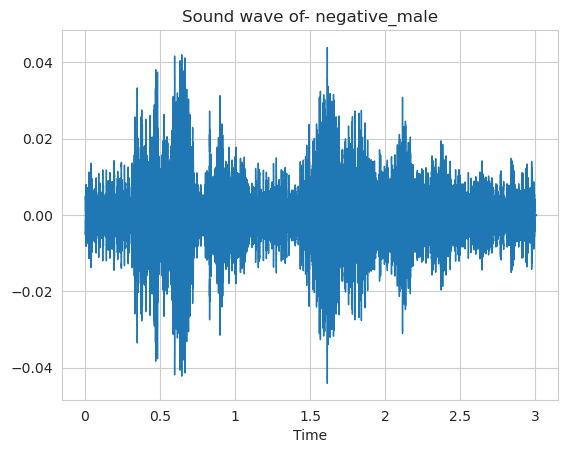

In [5]:
ind = np.random.randint(0,len(mydf))
data, sampling_rate = librosa.load(mydf['path'][ind], sr=44100)
emotion = mydf['emotion2'][ind]

plt.title(f'Sound wave of- {emotion}')
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

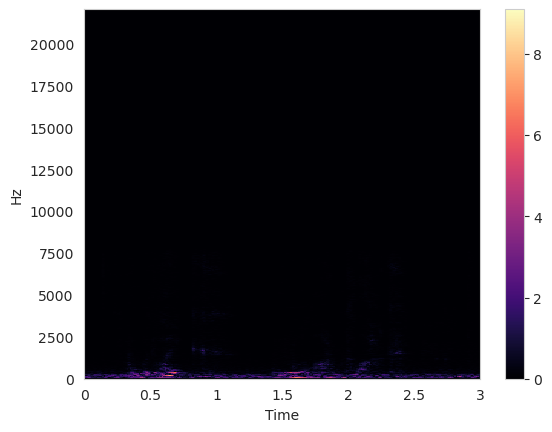

In [6]:
# Линейный спектр

D = np.abs(librosa.stft(data))
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='linear');
plt.colorbar()
plt.show()

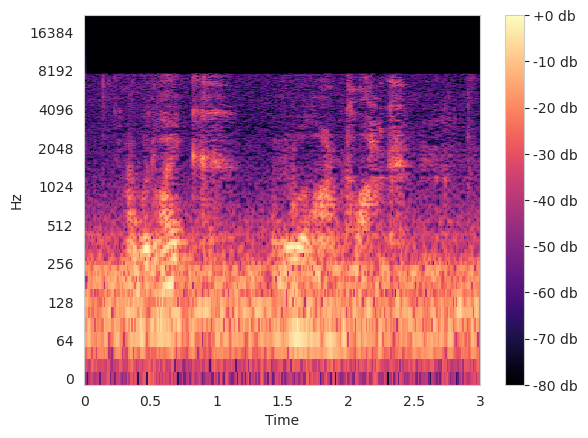

In [7]:
# log спектрограмма

DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sampling_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f db')
plt.show()

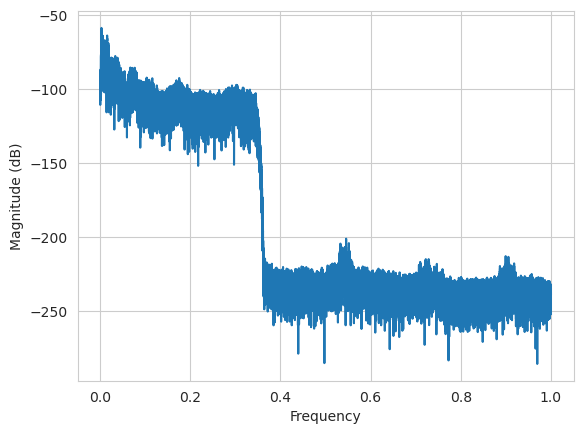

In [8]:
# log спектр

a = plt.magnitude_spectrum(data, scale='dB')
plt.show()

In [9]:
a1 = np.log(a[0])
a2 = a[1]

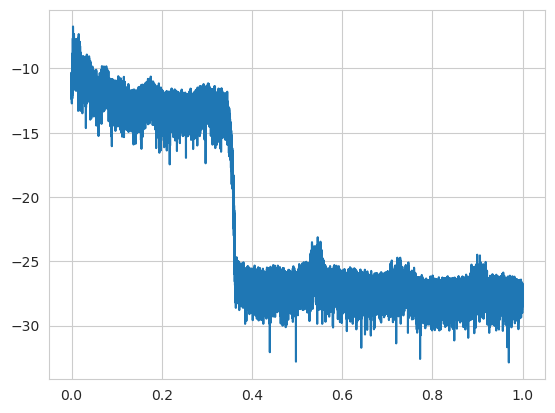

In [10]:
plt.plot(a2,a1)
plt.show()

In [11]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: одномерный массив, звуковой сигнал, из которого нужно извлечь высокие и низкие огибающие
    dmin, dmax: целые числа, необязательные параметры, размер фрагментов, используйте это, если размер входного сигнала слишком велик
    split: bool, необязательный параметр, если True, разделить сигнал пополам по его среднему значению, может помочь в генерации огибающей в некоторых случаях
    Output :
    lmin,lmax : индексы высокой/низкой огибающей входного сигнала s
    """
    
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    

    if split:
        s_mid = np.mean(s) 
        lmin = lmin[s[lmin]<s_mid]
        lmax = lmax[s[lmax]>s_mid]

    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]

    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]  
    
    return lmin,lmax

In [12]:
data.shape

(132433,)

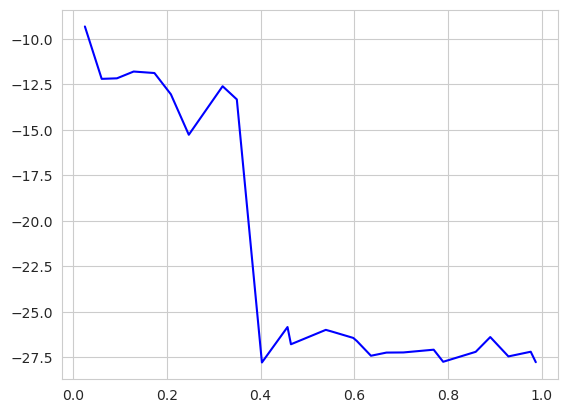

In [13]:
high_idx, _ = hl_envelopes_idx(data[:len(a1)], dmin=250)

plt.plot(a2[high_idx], a1[high_idx], 'b', label='low')
plt.show()

### Создаем df из MFCC и столбца 'emotion2' как меток

In [14]:
new_y = mydf['emotion2'].copy()

In [15]:
mydf['path']

0           TESS/OAF_Fear/OAF_ton_fear.wav
1           TESS/OAF_Fear/OAF_mob_fear.wav
2        TESS/OAF_Fear/OAF_bought_fear.wav
3          TESS/OAF_Fear/OAF_sell_fear.wav
4          TESS/OAF_Fear/OAF_doll_fear.wav
                       ...                
12157          CREMA-D/1091_WSI_DIS_XX.wav
12158          CREMA-D/1091_WSI_FEA_XX.wav
12159          CREMA-D/1091_WSI_HAP_XX.wav
12160          CREMA-D/1091_WSI_NEU_XX.wav
12161          CREMA-D/1091_WSI_SAD_XX.wav
Name: path, Length: 12162, dtype: object

In [16]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(f'{i}', sr=44000))

  0%|          | 0/12162 [00:00<?, ?it/s]

In [17]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

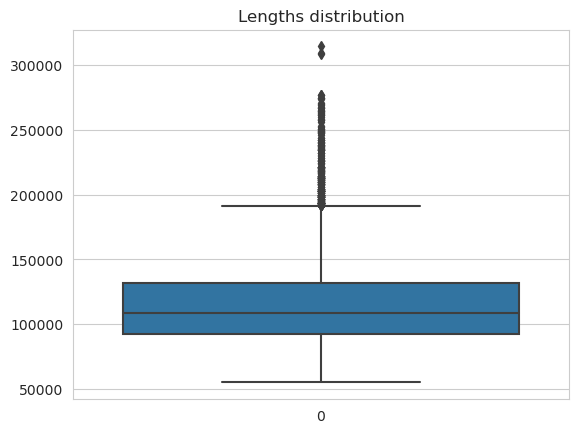

In [18]:
lengths = [len(x) for x in new_x]

plt.title('Lengths distribution')
sns.boxplot(lengths)
plt.show()

In [19]:
thresh = 300000

3


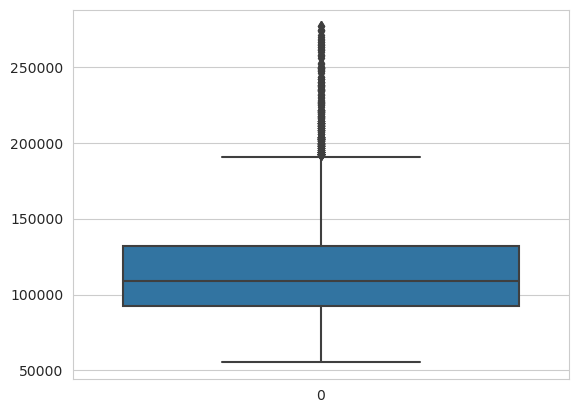

In [20]:
lengths = np.array(lengths)
print((lengths > thresh).sum())
new_lengths = lengths[lengths < thresh]

sns.boxplot(new_lengths)
plt.show()

In [21]:
new_lengths.mean()

115181.42116950407

In [22]:
length_chosen = 115181

In [23]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < thresh:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(new_y[ind])

In [24]:
from keras.preprocessing.sequence import pad_sequences
X_new_padded = pad_sequences(X_new, dtype='float32', padding='post')

In [25]:
X = np.array(X_new_padded)
y = np.array(y_new)
print(X.shape, y.shape)

(12159, 115182) (12159,)


In [26]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=20)
    mfcc = mfcc.T
    mfccs.append(mfcc)

  0%|          | 0/12159 [00:00<?, ?it/s]

In [27]:
mfccs = np.array(mfccs)

In [28]:
mydf.shape, mfccs.shape, y.shape

((12162, 7), (12159, 225, 20), (12159,))

In [29]:
#### Сохраняем

In [30]:
mfccs_path = 'mfccs.pickle'
y_path = 'y.pickle'

with open(mfccs_path, 'wb') as f:
    pickle.dump(mfccs,f)
    
with open(y_path, 'wb') as f:
    pickle.dump(y,f)

### Модель

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mfccs, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9727, 225, 20), (2432, 225, 20), (9727,), (2432,))

изменим значения нашей целевой переменной и расширим размер наших функций, чтобы они соответствовали нейронным сетям.

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

model = Sequential(
    [
     layers.Conv1D(64, 3, activation='relu', input_shape=(225,20)),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Conv1D(64, 3, activation='relu'),
     layers.MaxPooling1D(),
     layers.Flatten(),
     layers.Dense(64, activation="relu"),
     layers.Dense(6, activation="softmax")
    ]
)

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 223, 64)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 111, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 109, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 52, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 26, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       106,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,558 (529.52 KB)

 Trainable params: 135,558 (529.52 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.input_shape, model.output_shape

((None, 225, 20), (None, 6))

кодируем лейблы

In [35]:
set(y)

{'negative_female',
 'negative_male',
 'neutral_female',
 'neutral_male',
 'positive_female',
 'positive_male'}

In [36]:
emotions_encode = {'negative_female':0, 'negative_male':1, 'neutral_female':2, 'neutral_male':3,
                  'positive_female':4, 'positive_male':5}

In [37]:
y_train = pd.Series(y_train).map(emotions_encode)
y_test = pd.Series(y_test).map(emotions_encode)

In [38]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.2271 - val_loss: 0.8817
Epoch 2/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.9050 - val_loss: 0.8738
Epoch 3/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.7693 - val_loss: 0.7567
Epoch 4/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6965 - val_loss: 0.6630
Epoch 5/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6729 - val_loss: 0.6465
Epoch 6/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6256 - val_loss: 0.7083
Epoch 7/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6206 - val_loss: 0.6257
Epoch 8/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5684 - val_loss: 0.6234
Epoch 9/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.5508 - val_loss: 0.6048
Epoch 10/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5195 - val_loss: 0.6347
Epoch 11/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4914 - val_loss: 0.6483
Epoch 12/50
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

In [39]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
                 precision    recall  f1-score   support

negative_female       0.81      0.86      0.83       910
  negative_male       0.71      0.82      0.76       644
 neutral_female       0.68      0.74      0.71       202
   neutral_male       0.52      0.51      0.51       158
positive_female       0.84      0.62      0.72       320
  positive_male       0.50      0.27      0.35       198

       accuracy                           0.74      2432
      macro avg       0.68      0.64      0.65      2432
   weighted avg       0.73      0.74      0.73      2432



In [40]:
mydf['emotion2'].unique()

array(['negative_female', 'positive_female', 'neutral_female',
       'neutral_male', 'negative_male', 'positive_male'], dtype=object)

In [41]:
import tensorflow as tf

model2 = Sequential()

model2.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(225,20)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling1D(pool_size=(8)))
model2.add(layers.Dropout(0.1))

model2.add(layers.Conv1D(128, 5,padding='same'))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(6))
model2.add(layers.Activation('softmax'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 225, 256)       │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 225, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 28, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3584)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │        21,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,334 (825.52 KB)

 Trainable params: 211,334 (825.52 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, 
                                              verbose=1)

weight_path = 'best.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

In [43]:
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model2.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_test, y_test),
           callbacks=[reduce_lr, early_stop, model_checkpoint])

Epoch 1/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 6.7088 - val_loss: 1.2653 - learning_rate: 0.0010
Epoch 2/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.3009 - val_loss: 1.2488 - learning_rate: 0.0010
Epoch 3/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.2240 - val_loss: 1.1200 - learning_rate: 0.0010
Epoch 4/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.1494 - val_loss: 0.9570 - learning_rate: 0.0010
Epoch 5/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.0899 - val_loss: 0.8502 - learning_rate: 0.0010
Epoch 6/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.9615 - val_loss: 0.7782 - learning_rate: 0.0010
Epoch 7/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.8477 - val_loss: 0.7962 - learning_rate: 0.0010
Epoch 8/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.8466 - val_loss: 0.7612 - learning_rate: 0.0010
Epoch 9/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.8309 - val_loss: 0.7284 - learning_rate: 0

In [44]:
y_pred = model2.predict(X_test)
y_pred = [np.argmax(x) for x in y_pred]
print(classification_report(y_test, y_pred, target_names = list(emotions_encode.keys())))

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                 precision    recall  f1-score   support

negative_female       0.74      0.91      0.82       910
  negative_male       0.62      0.89      0.73       644
 neutral_female       0.87      0.43      0.58       202
   neutral_male       0.53      0.20      0.29       158
positive_female       0.89      0.53      0.67       320
  positive_male       0.45      0.11      0.17       198

       accuracy                           0.70      2432
      macro avg       0.68      0.51      0.54      2432
   weighted avg       0.70      0.70      0.67      2432



### Классификация эмоций - сначала нам нужно создать новые MFCC и массивы целевых значений

In [45]:
mydf['emotion3'].unique()

array(['fear_female', 'surprise_female', 'sad_female', 'negative_female',
       'positive_female', 'neutral_female', 'neutral_male',
       'negative_male', 'fear_male', 'sad_male', 'positive_male',
       'surprise_male'], dtype=object)

In [46]:
mydf['emotion3'].replace(['fear_female', 'fear_male'], 'fear', inplace=True)
mydf['emotion3'].replace(['surprise_female', 'surprise_male'], 'surprise', inplace=True)
mydf['emotion3'].replace(['sad_female', 'sad_male'], 'sadness', inplace=True)
mydf['emotion3'].replace(['negative_female', 'negative_male'], 'negetive', inplace=True)
mydf['emotion3'].replace(['positive_female', 'positive_male'], 'positive', inplace=True)
mydf['emotion3'].replace(['neutral_female', 'neutral_male'], 'neutral', inplace=True)

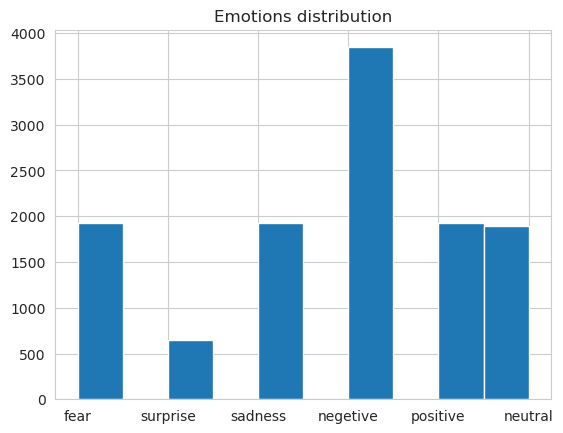

In [47]:
plt.title('Emotions distribution')
plt.hist(mydf['emotion3'])
# plt.hist(y)
plt.show()

In [48]:
y = mydf['emotion3'].copy()

In [49]:
mydf.head()

,emotion_label,source,actors,path,emotion2,emotion3,id
0,fear_female,TESS,female,TESS/OAF_Fear/OAF_ton_fear.wav,negative_female,fear,0
1,fear_female,TESS,female,TESS/OAF_Fear/OAF_mob_fear.wav,negative_female,fear,1
2,fear_female,TESS,female,TESS/OAF_Fear/OAF_bought_fear.wav,negative_female,fear,2
3,fear_female,TESS,female,TESS/OAF_Fear/OAF_sell_fear.wav,negative_female,fear,3
4,fear_female,TESS,female,TESS/OAF_Fear/OAF_doll_fear.wav,negative_female,fear,4


In [50]:
y.shape

(12162,)

In [51]:
X = []
for i in tqdm(mydf['path']):
    X.append(librosa.load(i, sr=44000))

  0%|          | 0/12162 [00:00<?, ?it/s]

In [52]:
new_x = []
for ind,i in enumerate(X):
    new_x.append(i[0])

In [53]:
lengths = [len(x) for x in new_x]

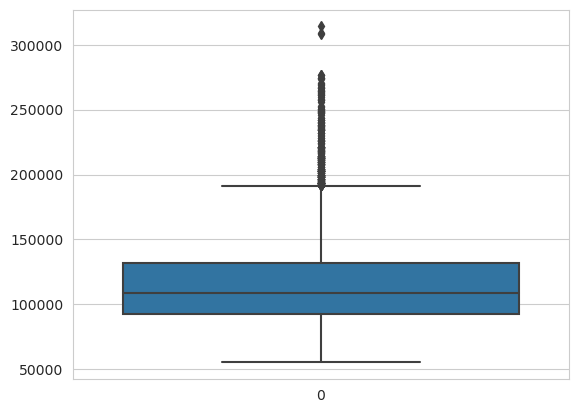

In [54]:
sns.boxplot(lengths)
plt.show()

3


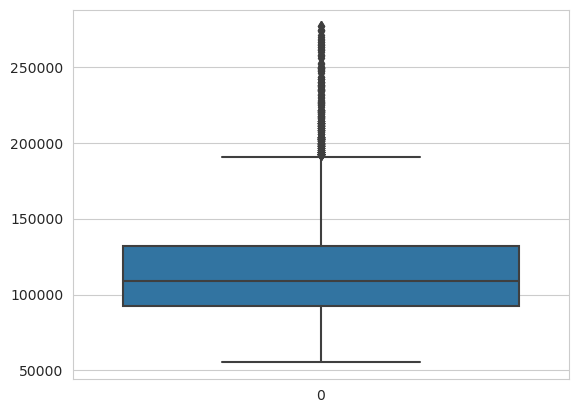

In [55]:
lengths = np.array(lengths)
print((lengths > 300000).sum())
new_lengths = lengths[lengths < 300000]

sns.boxplot(new_lengths)
plt.show()

In [56]:
print(new_lengths.mean())

115181.42116950407


In [57]:
length_chosen = 115181

In [58]:
import math

X_new = []
y_new = []
for ind,i in enumerate(new_x):
    if i.shape[0] < 300000:
        if i.shape[0] > length_chosen:
            new = i[:length_chosen]
            X_new.append(new)
        elif i.shape[0] < length_chosen:
            new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
            X_new.append(new)
        else:
            X_new.append(i)
            
        y_new.append(y[ind])

In [60]:
from keras.preprocessing.sequence import pad_sequences
X_new_padded = pad_sequences(X_new, dtype='float32', padding='post')

In [61]:
X = np.array(X_new_padded)
y = np.array(y_new)
print(X.shape, y.shape)

(12159, 115182) (12159,)


In [62]:
mfccs = []
for i in tqdm(X):
    mfcc = librosa.feature.mfcc(y=i, sr=44000, n_mfcc=40)
    mfcc = mfcc.T
    mfccs.append(mfcc)

  0%|          | 0/12159 [00:00<?, ?it/s]

In [63]:
mfccs = np.array(mfccs)
mfccs.shape

(12159, 225, 40)

In [64]:
set(y)

{'fear', 'negetive', 'neutral', 'positive', 'sadness', 'surprise'}

In [150]:
import pickle 

mfccs2_path = 'mfccs2.pickle'
y2_path = 'y2.pickle'

# with open(mfccs2_path, 'wb') as f:
#     pickle.dump(mfccs,f)
    
# with open(y2_path, 'wb') as f:
#     pickle.dump(y,f)
    
with open(mfccs2_path, 'rb') as f:
    mfccs = pickle.load(f)
    
with open(y2_path, 'rb') as f:
    y = pickle.load(f)

In [151]:
set(y)

{'fear', 'negetive', 'neutral', 'positive', 'sadness', 'surprise'}

In [152]:
y = np.where(y=='positive', 'happy', y)
y = np.where(y=='negetive', 'disgust', y)

In [153]:
set(y)

{'disgust', 'fear', 'happy', 'neutral', 'sadness', 'surprise'}

In [154]:
emotion_enc = {'fear':0, 'disgust':1, 'neutral':2, 'happy':3, 'sadness':4, 'surprise':5}

In [155]:
X_train, X_val, y_train, y_val = train_test_split(mfccs, y, test_size=0.2, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=15)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9727, 225, 40), (1216, 225, 40), (1216, 225, 40), (9727,), (1216,), (1216,))

In [156]:
y_train = pd.Series(y_train).map(emotion_enc)
y_val = pd.Series(y_val).map(emotion_enc)
y_test = pd.Series(y_test).map(emotion_enc)

In [157]:
y_train.unique(), y_test.unique(), y_val.unique()

(array([5, 1, 0, 3, 2, 4]),
 array([1, 2, 5, 0, 4, 3]),
 array([1, 4, 3, 2, 0, 5]))

In [158]:
model3 = Sequential()

model3.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(225,40)))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(8)))
model3.add(layers.Dropout(0.2))

model3.add(layers.Conv1D(128, 5,padding='same'))
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling1D(pool_size=(4)))
model3.add(layers.Dropout(0.1))

model3.add(layers.Flatten())
model3.add(layers.Dense(64))
model3.add(layers.Dense(7))
model3.add(layers.Activation('softmax'))

model3.summary()

model2 = Sequential()

model2.add(layers.Conv1D(256, 5,padding='same',
                 input_shape=(225,20)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling1D(pool_size=(8)))
model2.add(layers.Dropout(0.1))

model2.add(layers.Conv1D(128, 5,padding='same'))
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(6))
model2.add(layers.Activation('softmax'))

model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)              │ (None, 225, 256)       │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 225, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 28, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 28, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 28, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 7)              │           455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,287 (1.04 MB)

 Trainable params: 273,287 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
weight_path2 = 'best_weights2.weights.h5'

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint2 = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path2, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)

In [160]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model3.fit(X_train, y_train, batch_size=16, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint2])

Epoch 1/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 12.9667 - val_loss: 1.3056 - learning_rate: 0.0010
Epoch 2/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.3021 - val_loss: 1.1612 - learning_rate: 0.0010
Epoch 3/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.2072 - val_loss: 1.1310 - learning_rate: 0.0010
Epoch 4/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.1705 - val_loss: 1.1084 - learning_rate: 0.0010
Epoch 5/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.1473 - val_loss: 1.1433 - learning_rate: 0.0010
Epoch 6/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.1484 - val_loss: 1.1369 - learning_rate: 0.0010
Epoch 7/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.1340 - val_loss: 1.1725 - learning_rate: 0.0010
Epoch 8/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.1496 - val_loss: 1.1401 - learning_rate: 0.0010
Epoch 9/500
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.1176 - val_loss: 1.1167 - learning_rate

### Финал

In [161]:
def report_res_and_plot_matrix(y_test, y_pred, plot_classes):

  acc = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {acc:.4f}")

  cnf_matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
    
  tick_marks = np.arange(len(plot_classes))
  plt.xticks(ticks=tick_marks, labels=plot_classes, rotation=90)
  plt.yticks(ticks=tick_marks, labels=plot_classes, rotation=90)

  group_counts = [f'{value:0.0f}' for value in cnf_matrix.flatten()]
  group_percentages = [f'{100 * value:0.1f} %' for value in 
                       cnf_matrix.flatten()/np.sum(cnf_matrix)]
  labels = [f'{v1}\n({v2})' for v1, v2 in
            zip(group_counts,group_percentages)]
  n = int(np.sqrt(len(labels)))
  labels = np.asarray(labels).reshape(n,n)
  sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues',
              xticklabels=plot_classes, yticklabels=plot_classes)


  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

  return [acc, cnf_matrix]

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

        fear       0.60      0.57      0.58       200
     disgust       0.84      0.66      0.74       407
     neutral       0.59      0.68      0.63       166
       happy       0.43      0.65      0.51       175
     sadness       0.57      0.53      0.55       195
    surprise       0.87      0.79      0.83        73

    accuracy                           0.63      1216
   macro avg       0.65      0.65      0.64      1216
weighted avg       0.67      0.63      0.64      1216

Accuracy: 0.6349


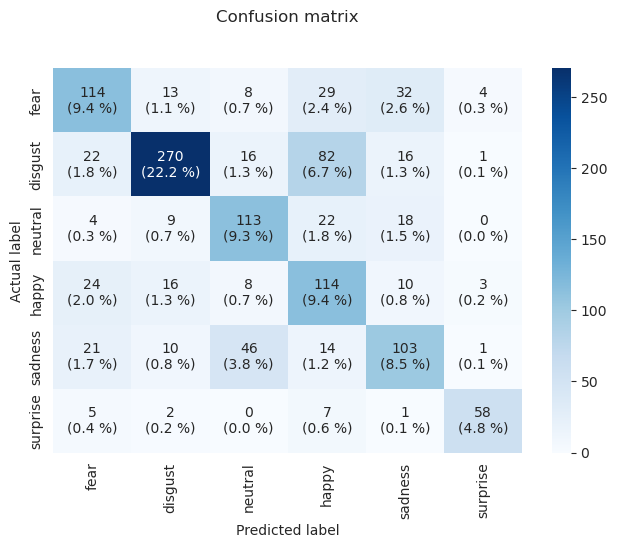

In [162]:
from sklearn.metrics import classification_report

y_pred = model3.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=list(emotion_enc.keys())))
params = report_res_and_plot_matrix(y_test, y_pred, list(emotion_enc.keys()))

визуализация классов

In [163]:
X_test.shape, X_train.shape, y_pred.shape

((1216, 225, 40), (9727, 225, 40), (1216,))

In [169]:
X_test_new = X_test.reshape(1216,-1).copy()
X_train_new = X_train.reshape(9727,-1).copy()

In [170]:
X_test_new.shape, X_train_new.shape

((1216, 9000), (9727, 9000))

In [172]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_scaled = scaler.transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

In [173]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit_transform(X_train_scaled)
X_pca = pca.transform(X_test_scaled)

In [174]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0).fit(X_pca)
labels = kmeans.labels_

In [175]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

осталось понять какой кейс лучше

In [176]:
set(y_pred)

{0, 1, 2, 3, 4, 5}

In [177]:
l = pd.get_dummies(labels)
p = pd.get_dummies(y_pred)

l.shape, p.shape

((1216, 7), (1216, 6))

In [178]:
h = pd.merge(l, p, left_index=True, right_index=True)

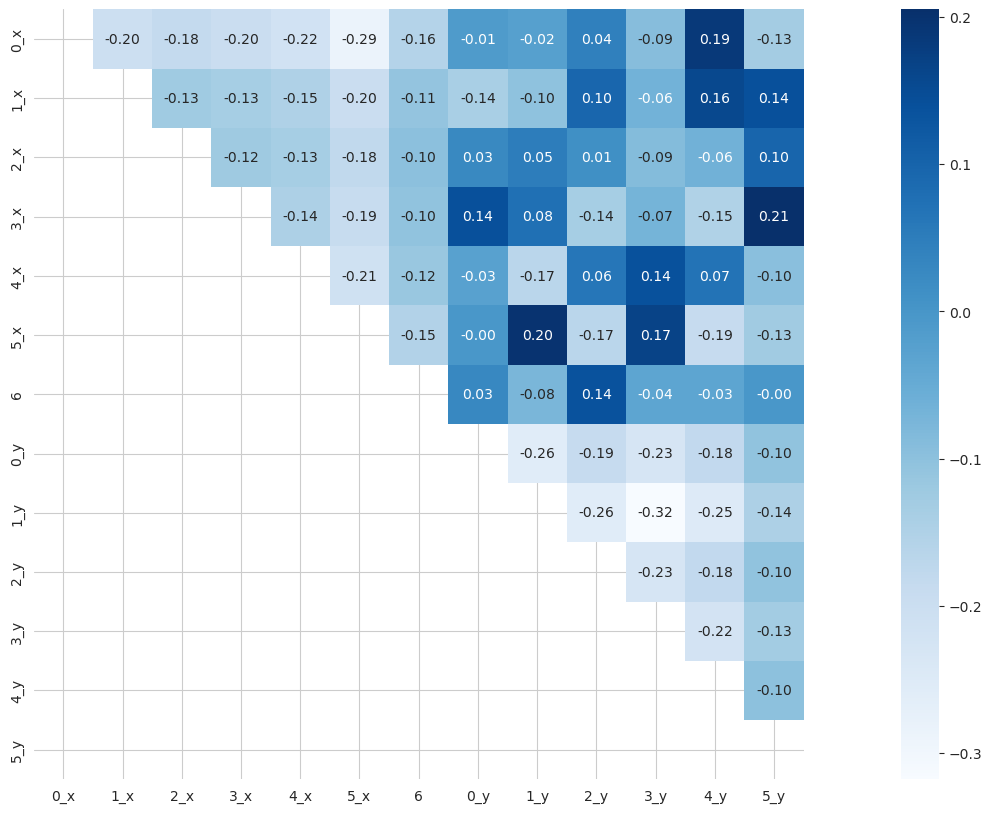

In [180]:
corr = h.corr(method='spearman')
mask = np.tril(np.ones_like(corr, dtype=bool))
ax = plt.figure(figsize=(25,10))
ax = sns.heatmap(h.corr(method='spearman'), annot=True, fmt=".2f", mask = mask, square = True, cmap="Blues")

In [181]:
a = pd.DataFrame(labels)
b= pd.DataFrame(y_pred)
c= pd.DataFrame()
c['labels'] = a[0].copy()
c['preds'] = b[0].copy()

In [182]:
c.head()

,labels,preds
0,0,4
1,5,1
2,4,2
3,0,2
4,3,1


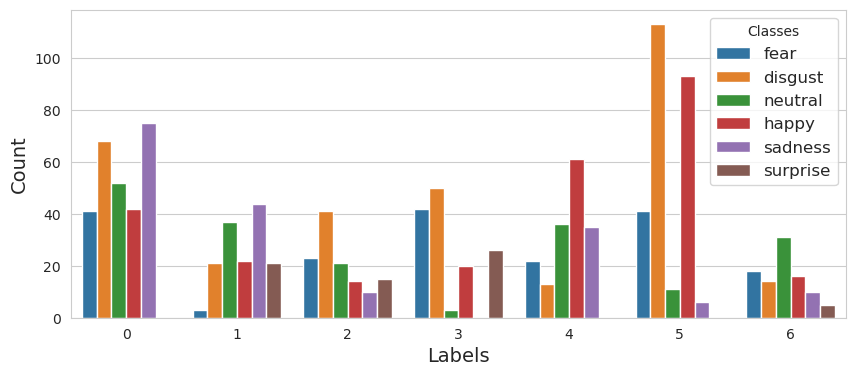

In [183]:
plt.figure(figsize=(10,4))
sns.countplot(x='labels', hue="preds", data=c)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Classes', bbox_to_anchor = (1,1), labels=list(emotion_enc.keys()), fontsize='large')
plt.show()

In [184]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5}

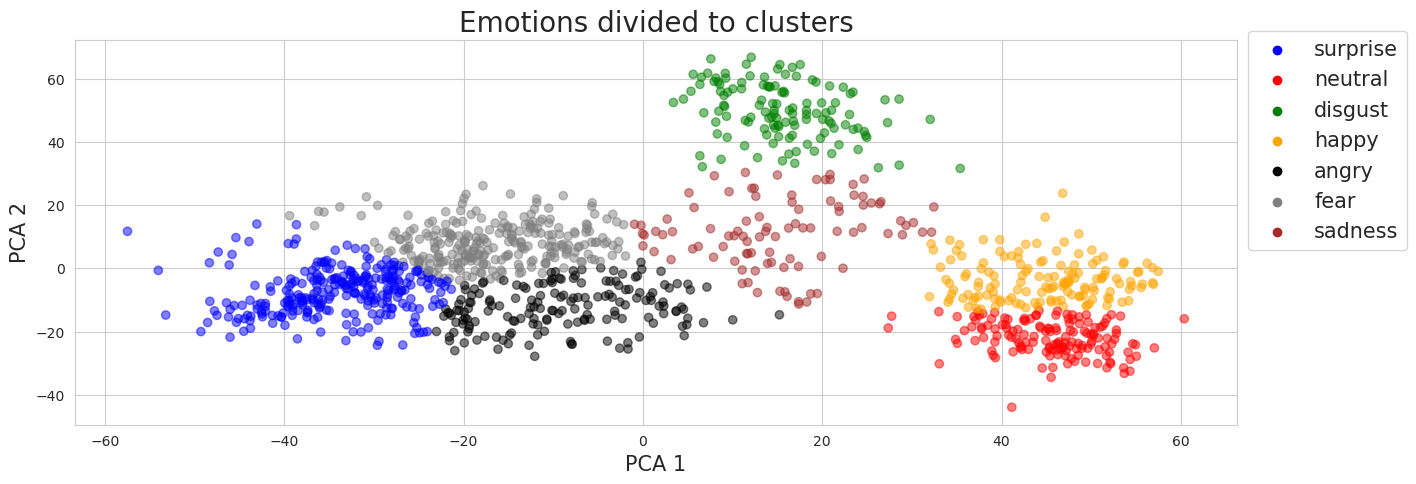

In [185]:
colors = {0:'blue', 1:'red', 2:'green', 3:'orange', 4:'black', 5:'grey', 6:'brown'}
lab = ['surprise', 'neutral', 'disgust', 'happy', 'angry', 'fear', 'sadness']


fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(111)
ax.scatter(X_pca[:, 0], X_pca[:, 1], c = pd.Series(labels).map(colors), alpha=0.5)
for i in range(7):
    plt.scatter(None, None, color=colors[i], label=lab[i])

plt.title('Emotions divided to clusters', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor= [1, 1.05])
plt.xlabel('PCA 1', fontsize=15)
plt.ylabel('PCA 2', fontsize=15)
plt.show()

сохраняем модели

In [2]:
import tensorflow as tf

# model2.save('model2.h5')
# model3.save('model3.h5')

model3 = tf.keras.models.load_model('model3.h5')

2024-04-21 03:50:04.419273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-21 03:50:04.419534: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [187]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5}

проверим рандомные семплы из датасета

In [189]:
x,sr = librosa.load('RAVDESS/Actor_01/03-01-04-02-02-01-01.wav', sr=44000)

In [190]:
x.shape, length_chosen

((164432,), 115181)

In [191]:
if x.shape[0] > length_chosen:
        new = x[:length_chosen]
elif x.shape[0] < length_chosen:
        new = np.pad(x,math.ceil((length_chosen-x.shape[0])/2), mode='median')
else:
        new = x

In [192]:
mfcc = librosa.feature.mfcc(y=new, sr=44000, n_mfcc=40)
mfcc = mfcc.T
mfcc.shape

(225, 40)

In [194]:
mfcc = mfcc.reshape(1,225,40)
mfcc.shape
p = model3.predict(mfcc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [195]:
p.argmax()

4

In [196]:
emotion_enc

{'fear': 0,
 'disgust': 1,
 'neutral': 2,
 'happy': 3,
 'sadness': 4,
 'surprise': 5}